# BAYESIAN ARDL

In [1]:
using DataFrames
using Distributions
using Gadfly
Gadfly.push_theme(:dark)
srand(123);

include(joinpath(homedir(), "Dropbox/MS THESIS/JULIA/MH.jl"));

in_dir = joinpath(homedir(), "Dropbox/MS THESIS/JULIA/INPUT");
lei_data = readtable(joinpath(in_dir, "Cycles LEI Data.csv"));
indicators =  lei_data[:, collect(2:8)];
x = Array(indicators[:, 2:7]);
y = Array(indicators[:, 1]);

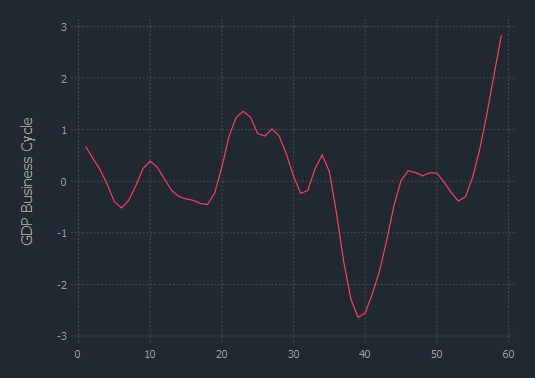

In [2]:
series = DataFrame(Y = y);
plot(series, y = :Y, Geom.line(), Guide.ylabel("GDP Business Cycle"))

In [3]:
"""
ARDL(1, 1)
"""
y_1 = [mean(y[1:(end - 1)]); y[1:(end - 1)]];
x_1 = [mapslices(mean, x[1:(end - 1), :], [1]); x[1:(end - 1), :]];
n_params = 1 + length(size(y_1)) + size(x)[2] + size(x_1)[2]

"""
The log likelihood function is given by the following codes:
"""
function loglike(theta::Array{Float64})
  yhat = theta[1] + theta[2] * y_1
  for i in 1:(size(x)[2])
    yhat += theta[i + 2] * x[:, i] + theta[i + 2 + size(x)[2]] * x_1[:, i]
  end

  likhood = Float64[]
  for i in 1:length(yhat)
    push!(likhood, log(pdf(Normal(yhat[i], alpha), y[i])))
  end

  return likhood |> sum
end

"""
Define the Prior Distribution
"""
function logprior(theta::Array{Float64})
  w_prior = [log(pdf(Normal(mu[i], s[i]), theta[i])) for i in 1:(n_params)]

  return w_prior |> sum
end

"""
Define the Posterior Distribution
"""
function logpost(theta::Array{Float64})
  loglike(theta) + logprior(theta)
end

logpost

## METROPOLIS-HASTING

In [4]:
"""
Do Bayesian Estimation using Metropolis-Hasting
"""
alpha = 1 / 5.;
mu = zeros(n_params);
s = ones(n_params);

mh_object = MH(logpost; init_est = ones(n_params), d = n_params);
@time chain1 = mcmc(mh_object, r = 100000);

200.887145 seconds (133.03 M allocations: 6.771 GB, 0.36% gc time)


In [5]:
"""
Plot it
"""
est1 = mapslices(mean, chain1[1000:end, :], [1]);

yhat = est1[1] + est1[2] * y_1
for i in 1:(size(x)[2])
  yhat += est1[i + 2] * x[:, i] + est1[i + 2 + size(x)[2]] * x_1[:, i]
end

yhat_std = (yhat - mean(yhat)) / std(yhat)
series[:yhat_std] = yhat_std;

for i in 1:size(chain1[1000:end, :])[1]
  yhat = chain1[i, 1] + chain1[i, 2] * y_1
  for j in 1:(size(x)[2])
    yhat += chain1[i + 2, j] * x[:, j] + chain1[i + 2 + size(x)[2], j] * x_1[:, j]
  end

  series[Symbol("yhat_std_", string(i))] = (yhat - mean(yhat)) / std(yhat)
end

In [6]:
series_stacked = DataFrame(
  x = repeat(collect(1:nrow(series)), outer = size(chain1[1000:end, :])[1]),
  var = Array(stack(series[:, 3:end])[1]),
  val = Array(stack(series[:, 3:end])[2])
  );

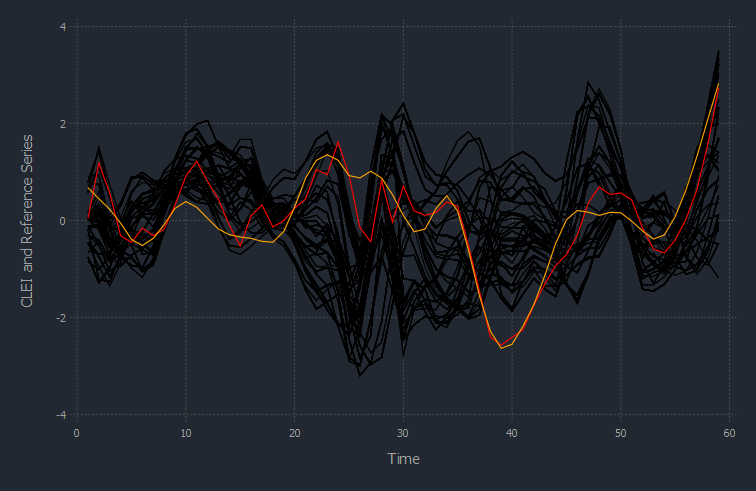

In [7]:
p1 = plot(layer(series, y = :Y, Geom.line, style(default_color = colorant"orange")),
     layer(series, y = :yhat_std, Geom.line, style(default_color = colorant"red")),
     layer(series_stacked, x = :x, y = :val, group = :var, Geom.line, style(default_color = colorant"black")),
     Guide.xlabel("Time"), Guide.ylabel("CLEI and Reference Series")
  )

draw(PNG(20cm, 13cm), p1)

## HAMILTONIAN MONTE CARLO

In [5]:
using TimeSeries

INFO: Precompiling module TimeSeries.


In [6]:
[Date(2000,1,3):Date(2000,4,4)]

1-element Array{StepRange{Date,Base.Dates.Day},1}:
 2000-01-03:1 day:2000-04-04

LoadError: MethodError: no method matching lead(::Array{Int64,1})[0m
Closest candidates are:
  lead{T,N}([1m[31m::TimeSeries.TimeArray{T,N,D<:Base.Dates.TimeType,A<:AbstractArray}[0m) at C:\Users\Al Asaad\.julia\v0.5\TimeSeries\src\apply.jl:162
  lead{T,N}([1m[31m::TimeSeries.TimeArray{T,N,D<:Base.Dates.TimeType,A<:AbstractArray}[0m, [1m[31m::Int64[0m; padding, period) at C:\Users\Al Asaad\.julia\v0.5\TimeSeries\src\apply.jl:162[0m